In [ ]:
import numpy as np
import networkx as nx
import random
import warnings
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
import community.community_louvain as comm_cl
from sklearn.metrics import accuracy_score, f1_score
from statistics import mean
from copy import deepcopy
from sys import getsizeof

In [ ]:
graphfile = 'cora.txt'
labelfile = 'cora.nodes.labels'
G = nx.read_edgelist(graphfile, nodetype=None)
G = G.to_directed()
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

Number of nodes:  2708
Number of edges:  10556


### Function to read node labels files

In [ ]:
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

### Helper Functions for node2vec

In [ ]:
# healpers for node2vec
def create_alias_table(area_ratio):
    """

    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
            (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias

def alias_sample(accept, alias):
    """

    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

def get_alias_edge(G, p, q, t, v):
        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

### Helper function to get embeddings

In [ ]:
def get_embedding(G, walks, embed_size=128, window_size=5, workers=3, iter=5, **kwargs):
    kwargs["sentences"] = walks
    kwargs["min_count"] = kwargs.get("min_count", 0)
    kwargs["vector_size"] = embed_size
    kwargs["sg"] = 1  # skip gram
    kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
    kwargs["workers"] = workers
    kwargs["window"] = window_size
    kwargs["epochs"] = iter

    print("Learning embedding vectors...")
    model = Word2Vec(**kwargs)
    print("Learning embedding vectors done!")

    embeddings = {}
    for word in G.nodes():
        embeddings[word] = model.wv[word]
    return embeddings

### Deepwalk

In [ ]:
def deepwalk_walks(G, num_walks, walk_length,):
        nodes = G.nodes()
        walks = []
        for _ in range(num_walks):
            for v in nodes:
                walk = [v]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = list(G.neighbors(cur))
                    if len(cur_nbrs) > 0:
                        walk.append(random.choice(cur_nbrs))
                    else:
                        break
                walks.append(walk)
        return walks

def node2vec_walks(G, p, q, num_walks, walk_length,):
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0)
                                  for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)

        alias_edges = {}

        for edge in G.edges():
            alias_edges[edge] = get_alias_edge(G, p, q, edge[0], edge[1])

        # generate walks
        nodes = G.nodes()
        walks = []
        for _ in range(num_walks):
            for v in nodes:
                walk = [v]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = list(G.neighbors(cur))
                    if len(cur_nbrs) > 0:
                        if len(walk) == 1:
                            walk.append(
                                cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                        else:
                            prev = walk[-2]
                            edge = (prev, cur)
                            next_node = cur_nbrs[alias_sample(alias_edges[edge][0],
                                                      alias_edges[edge][1])]
                            walk.append(next_node)
                    else:
                        break
                walks.append(walk)
        return walks


### OG Helper Functions

In [ ]:
# def node_classification(embeddings, label):
#     X, Y = read_node_label(label,skip_head=True)

#     #ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
#     ltrainfrac=[.7]
#     for tf in ltrainfrac:
#         print("Training classifier using {:.2f}% nodes...".format(tf * 100))
#         split_train_evaluate(X, Y, embeddings, tf)




# def makeLinkPredictionData(graph, embeddings):
#     # converting embedding to a numpy array
#     X = [[0] for i in range(G.number_of_nodes())]
#     for i in range(0, G.number_of_nodes()):
#         X[i] = embeddings[str(i+1)]
#     X = np.array(X)

#     Xd = []
#     Yd = []
#     count = 0
#     # for all vertices
#     for u in range(graph.number_of_nodes()):
#         Nu = list(graph.neighbors(u))
#         count += len(Nu)
#         cn = 0
#         totalns = 0
#         # for all neighbors of u
#         for n in Nu:
#             x = []
#             if n > u:
#                 for d in range(len(X[0])):
#                     x.append(X[u][d] - X[n][d]) # distance between the embeddings of u and its neighbor n
#                 Xd.append(x)
#                 Yd.append(1) # positive sample (edge present)
#                 totalns += 1
#         tmpnn = []
#         if len(Nu) > graph.number_of_nodes() // 2:
#             totalns = (graph.number_of_nodes() - len(Nu)) // 2
#             #print("Testing neighbors!")
#         while cn < totalns:
#             nn = random.randint(0, graph.number_of_nodes() - 1)
#             # non-neighbors of u
#             if nn not in Nu and nn not in tmpnn:
#                 cn += 1
#                 x = []
#                 for d in range(len(X[0])):
#                     x.append(X[u][d] - X[nn][d])
#                 Xd.append(x)
#                 Yd.append(0) # negative sample (edge absent)
#                 tmpnn.append(nn)
#     Xd, Yd = np.array(Xd), np.array(Yd)
#     indices = np.array(range(len(Yd)))
#     np.random.shuffle(indices)
#     Xt = Xd[indices]
#     Yt = Yd[indices]
#     #print(len(Xd), len(Yd), count)


#     #ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
#     ltrainfrac = [.7]
#     for tf in ltrainfrac:
#         CV = int(len(Yt) * tf)
#         trainX = Xt[0:CV]
#         testX = Xt[CV:]
#         trainY = Yt[0:CV]
#         testY = Yt[CV:]
#         modelLR = LogisticRegression().fit(trainX, trainY)
#         predictedY = modelLR.predict(testX)
#         acc = accuracy_score(predictedY, testY)
#         #f1macro = f1_score(predictedY, testY, average='macro', labels=np.unique(predictedY))
#         #f1micro = f1_score(predictedY, testY, average='micro', labels=np.unique(predictedY))
#         #print("Link predictions:", tf, ":Accuracy:",acc, "F1-macro:", f1macro, "F1-micro:",f1micro)
#         print("Link predictions:", tf, ":Accuracy:",acc)



# def cluster_eval(G, embeddings):
#     # converting embedding to a numpy array
#     X = [[0] for i in range(G.number_of_nodes())]
#     for i in range(0, G.number_of_nodes()):
#         X[i] = embeddings[str(i+1)]
#     X = np.array(X)

#     bestModularity = 0
# #     bestC = 2
# #     NOC = 30
#     allmodularity = []
#     for cls in range(10, 11):

#         # find clusters using a kmeans clustering algorithm on the embedding
#         # Number of clusters is set to cls
#         clusters = KMeans(n_clusters=cls, random_state=0).fit(X)
#         predG = dict()
#         for node in range(len(clusters.labels_)):
#             predG[node] = clusters.labels_[node]

#         # compute the modularity score of the Kmeans clustering
#         modularity = comm_cl.modularity(predG, G)
#         allmodularity.append(modularity)
#         print("Number of clusters: ", cls, "  Modularity: ", modularity)
#         if modularity > bestModularity:
#             bestModularity = modularity
#             bestC = cls
# #     plt.scatter(range(2, NOC), allmodularity)
# #     plt.xlabel("Number of clusters")
# #     plt.ylabel("Modularity score")
# #     plt.show()
#     #print("Best Modularity:",bestModularity, "Clusters:", bestC)



# def plot_embeddings(embeddings, label):

#     X, Y = read_node_label(label,skip_head=True)
#     emb_list = []
#     for k in X:
#         emb_list.append(embeddings[k])
#     emb_list = np.array(emb_list)

#     model = TSNE(n_components=2)
#     node_pos = model.fit_transform(emb_list)
#     color_idx = {}

#     for i in range(len(X)):
#         color_idx.setdefault(Y[i][0], [])
#         color_idx[Y[i][0]].append(i)

#     for c, idx in color_idx.items():
#         plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
#     plt.legend()
#     plt.show()

### Modified Helper Functions

In [ ]:

def node_classification(embeddings, label):
    X, Y = read_node_label(label,skip_head=True)

    #ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    ltrainfrac=[.7]
    for tf in ltrainfrac:
        # print("Training classifier using {:.2f}% nodes...".format(tf * 100))
        return split_train_evaluate(X, Y, embeddings, tf)




def makeLinkPredictionData(graph, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    for i in range(0, G.number_of_nodes()):
        X[i] = embeddings[str(i+1)]
    X = np.array(X)

    Xd = []
    Yd = []
    count = 0
    # for all vertices
    for u in range(graph.number_of_nodes()):
        Nu = list(graph.neighbors(u))
        count += len(Nu)
        cn = 0
        totalns = 0
        # for all neighbors of u
        for n in Nu:
            x = []
            if n > u:
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[n][d]) # distance between the embeddings of u and its neighbor n
                Xd.append(x)
                Yd.append(1) # positive sample (edge present)
                totalns += 1
        tmpnn = []
        if len(Nu) > graph.number_of_nodes() // 2:
            totalns = (graph.number_of_nodes() - len(Nu)) // 2
            #print("Testing neighbors!")
        while cn < totalns:
            nn = random.randint(0, graph.number_of_nodes() - 1)
            # non-neighbors of u
            if nn not in Nu and nn not in tmpnn:
                cn += 1
                x = []
                for d in range(len(X[0])):
                    x.append(X[u][d] - X[nn][d])
                Xd.append(x)
                Yd.append(0) # negative sample (edge absent)
                tmpnn.append(nn)
    Xd, Yd = np.array(Xd), np.array(Yd)
    indices = np.array(range(len(Yd)))
    np.random.shuffle(indices)
    Xt = Xd[indices]
    Yt = Yd[indices]
    #print(len(Xd), len(Yd), count)


    #ltrainfrac = [0.05, 0.1, 0.2, 0.3, .4, .5, .6, .7, .8]
    ltrainfrac = [.7]
    for tf in ltrainfrac:
        CV = int(len(Yt) * tf)
        trainX = Xt[0:CV]
        testX = Xt[CV:]
        trainY = Yt[0:CV]
        testY = Yt[CV:]
        modelLR = LogisticRegression().fit(trainX, trainY)
        predictedY = modelLR.predict(testX)
        acc = accuracy_score(predictedY, testY)
        #f1macro = f1_score(predictedY, testY, average='macro', labels=np.unique(predictedY))
        #f1micro = f1_score(predictedY, testY, average='micro', labels=np.unique(predictedY))
        #print("Link predictions:", tf, ":Accuracy:",acc, "F1-macro:", f1macro, "F1-micro:",f1micro)
        # print("Link predictions:", tf, ":Accuracy:",acc)
    return acc



def cluster_eval(G, embeddings):
    # converting embedding to a numpy array
    X = [[0] for i in range(G.number_of_nodes())]
    for i in range(0, G.number_of_nodes()):
        X[i] = embeddings[str(i+1)]
    X = np.array(X)

    bestModularity = 0
#     bestC = 2
#     NOC = 30
    allmodularity = []
    for cls in range(10, 11):

        # find clusters using a kmeans clustering algorithm on the embedding
        # Number of clusters is set to cls
        clusters = KMeans(n_clusters=cls, random_state=0).fit(X)
        predG = dict()
        for node in range(len(clusters.labels_)):
            predG[node] = clusters.labels_[node]

        # compute the modularity score of the Kmeans clustering
        modularity = comm_cl.modularity(predG, G)
        allmodularity.append(modularity)
        # print("Number of clusters: ", cls, "  Modularity: ", modularity)
        return modularity
        # if modularity > bestModularity:
        #     bestModularity = modularity
        #     bestC = cls
#     plt.scatter(range(2, NOC), allmodularity)
#     plt.xlabel("Number of clusters")
#     plt.ylabel("Modularity score")
#     plt.show()
    #print("Best Modularity:",bestModularity, "Clusters:", bestC)


def plot_embeddings(embeddings, label):

    X, Y = read_node_label(label,skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}

    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()

### Modified Helper Functions 2

In [ ]:
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


def split_train_evaluate(X, Y, embeddings, train_precent, seed=0):
    state = np.random.get_state()
    training_size = int(train_precent * len(X))
    np.random.seed(seed)
    shuffle_indices = np.random.permutation(np.arange(len(X)))
    X_train = [X[shuffle_indices[i]] for i in range(training_size)]
    Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
    X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
    Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

    # train
    binarizer = MultiLabelBinarizer(sparse_output=True)
    binarizer.fit(Y)
    X_tr = [embeddings[x] for x in X_train]
    Y_tr = binarizer.transform(Y_train)
    clf=TopKRanker(LogisticRegression())
    clf.fit(X_tr, Y_tr)

    np.random.set_state(state)
    top_k_list = [len(l) for l in Y_test]
    X_test = np.asarray([embeddings[x] for x in X_test])
    Y_pred = clf.predict(X_test, top_k_list=top_k_list)
    results = {}
    results['acc'] = accuracy_score(binarizer.transform(Y_test),Y_pred)
    # print('-------------------')
    # print(results)
    # print('-------------------')
    return results['acc']



### OG Helper Functions 2

In [ ]:
# class TopKRanker(OneVsRestClassifier):
#     def predict(self, X, top_k_list):
#         probs = np.asarray(super(TopKRanker, self).predict_proba(X))
#         all_labels = []
#         for i, k in enumerate(top_k_list):
#             probs_ = probs[i, :]
#             labels = self.classes_[probs_.argsort()[-k:]].tolist()
#             probs_[:] = 0
#             probs_[labels] = 1
#             all_labels.append(probs_)
#         return np.asarray(all_labels)

# def split_train_evaluate(X, Y, embeddings, train_precent, seed=0):
#     state = np.random.get_state()
#     training_size = int(train_precent * len(X))
#     np.random.seed(seed)
#     shuffle_indices = np.random.permutation(np.arange(len(X)))
#     X_train = [X[shuffle_indices[i]] for i in range(training_size)]
#     Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
#     X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
#     Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

#     # train
#     binarizer = MultiLabelBinarizer(sparse_output=True)
#     binarizer.fit(Y)
#     X_tr = [embeddings[x] for x in X_train]
#     Y_tr = binarizer.transform(Y_train)
#     clf=TopKRanker(LogisticRegression())
#     clf.fit(X_tr, Y_tr)

#     np.random.set_state(state)
#     top_k_list = [len(l) for l in Y_test]
#     X_test = np.asarray([embeddings[x] for x in X_test])
#     Y_pred = clf.predict(X_test, top_k_list=top_k_list)
#     results = {}
#     results['acc'] = accuracy_score(binarizer.transform(Y_test),Y_pred)
#     print('-------------------')
#     print(results)
#     print('-------------------')


# Generate Embeddings

In [ ]:
G1 = G.to_undirected()
# converting node labes to integers for indexing in modularity computation
G1 = nx.relabel_nodes(G1, lambda x: int(x)-1)

In [ ]:
# for i in [10]:
#     print("For walk length as ", {i})
#     walks_deepwalk = deepwalk_walks(G, walk_length=i, num_walks=80)
#     embeddings_deepwalk = get_embedding(G,walks_deepwalk)
#     node_classification(embeddings_deepwalk, labelfile)
#     cluster_eval(G1, embeddings_deepwalk)
#     makeLinkPredictionData(G1, embeddings_deepwalk)

In [ ]:
for i in [10]:
    print("For walk length as ", {i})
    walks_deepwalk = deepwalk_walks(G, walk_length=i, num_walks=80)
    embeddings_deepwalk = get_embedding(G,walks_deepwalk)


For walk length as  {10}
Learning embedding vectors...


Learning embedding vectors done!


In [ ]:
print(embeddings_deepwalk.keys())

dict_keys(['1057', '1078', '478', '1100', '1489', '1421', '1075', '2686', '2458', '805', '856', '2271', '1058', '1914', '1293', '1323', '1595', '738', '84', '2113', '2131', '2060', '836', '496', '864', '2036', '2334', '1910', '278', '2649', '618', '1868', '2609', '557', '85', '2532', '1427', '2185', '1266', '1242', '279', '1924', '2449', '1573', '887', '2360', '1071', '625', '2648', '1136', '1866', '733', '1505', '1803', '10', '882', '815', '1059', '1915', '1958', '215', '1246', '2005', '735', '1218', '2028', '549', '1838', '955', '1232', '1824', '2490', '1194', '1372', '1841', '2278', '2283', '1305', '2553', '1559', '57', '781', '2220', '2457', '626', '2378', '1991', '99', '2452', '2352', '1431', '915', '1381', '1898', '313', '1684', '1089', '1714', '943', '995', '1018', '13', '959', '2372', '546', '55', '1010', '1734', '542', '458', '875', '2476', '993', '668', '2604', '2018', '354', '1234', '2526', '2387', '488', '804', '1713', '2472', '1836', '280', '1413', '1445', '1002', '797', '

In [ ]:
len(dict(list(embeddings_deepwalk.items())))

2708

In [ ]:
dw_dict=dict(list(embeddings_deepwalk.items()))

In [ ]:
print(dw_dict.keys())

dict_keys(['1057', '1078', '478', '1100', '1489', '1421', '1075', '2686', '2458', '805', '856', '2271', '1058', '1914', '1293', '1323', '1595', '738', '84', '2113', '2131', '2060', '836', '496', '864', '2036', '2334', '1910', '278', '2649', '618', '1868', '2609', '557', '85', '2532', '1427', '2185', '1266', '1242', '279', '1924', '2449', '1573', '887', '2360', '1071', '625', '2648', '1136', '1866', '733', '1505', '1803', '10', '882', '815', '1059', '1915', '1958', '215', '1246', '2005', '735', '1218', '2028', '549', '1838', '955', '1232', '1824', '2490', '1194', '1372', '1841', '2278', '2283', '1305', '2553', '1559', '57', '781', '2220', '2457', '626', '2378', '1991', '99', '2452', '2352', '1431', '915', '1381', '1898', '313', '1684', '1089', '1714', '943', '995', '1018', '13', '959', '2372', '546', '55', '1010', '1734', '542', '458', '875', '2476', '993', '668', '2604', '2018', '354', '1234', '2526', '2387', '488', '804', '1713', '2472', '1836', '280', '1413', '1445', '1002', '797', '

In [ ]:

print((dw_dict['1057']))

[ 0.09047645 -0.14208786 -0.28767192  0.23217894  0.11459475 -0.16162781
  0.32755572  0.12986556  0.2451656  -0.09149787 -0.287595   -0.27466613
 -0.31602642  0.1720658   0.0376435   0.1083737  -0.09422169  0.19819888
 -0.11794829  0.24590062  0.03305842  0.12269654 -0.1649902   0.11762441
  0.19540936  0.02827001  0.38004065 -0.07901358 -0.12009753  0.00630609
  0.04295869  0.10333033  0.11563729 -0.28870428 -0.01510959  0.25142375
  0.20694171  0.28118557  0.04107682 -0.0603718   0.05279202 -0.09008104
  0.19109611 -0.21228336  0.05618869 -0.21880949 -0.23317847  0.29274505
 -0.15788937  0.26034316  0.16475016 -0.19522668 -0.14319807 -0.44559678
 -0.21810807 -0.18423449  0.12507294 -0.0830951  -0.13806821  0.2717139
 -0.08942094 -0.12963393 -0.20803991 -0.575708    0.10244101 -0.06306438
  0.01245595  0.12755017  0.01679983  0.3466767   0.22203322  0.11388357
 -0.42849615 -0.0635228   0.24778834 -0.12168045  0.05390391 -0.03674008
  0.01152644  0.07186933  0.16123886  0.46474084 -0.

# Performing Tasks using OG Embeddings

In [ ]:
node_classification(embeddings_deepwalk, labelfile)
cluster_eval(G1, embeddings_deepwalk)
makeLinkPredictionData(G1, embeddings_deepwalk)

Training classifier using 70.00% nodes...
-------------------
{'acc': 0.800982800982801}
-------------------
Number of clusters:  10   Modularity:  0.7594863698844437
Link predictions: 0.7 :Accuracy: 0.5674139564256394


# Performing Tasks using Embeddings Sparsified based on Percentage of Sparsification


In [ ]:
import random

def randomly_sparsify_embeddings(embeddings, sparsity_percentage):
    sparsified_embeddings = {}
    for node, vector in embeddings.items():
        # Calculate the number of values to delete
        num_values_to_delete = int(len(vector) * sparsity_percentage)

        # Randomly select indices to delete
        indices_to_delete = random.sample(range(len(vector)), num_values_to_delete)

        # Create a sparsified vector by setting selected indices to 0
        sparsified_vector = [val if idx not in indices_to_delete else 0 for idx, val in enumerate(vector)]

        sparsified_embeddings[node] = sparsified_vector

    return sparsified_embeddings

In [ ]:
vals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # add 1 at the end

for j in vals:
  spdw_dict=randomly_sparsify_embeddings(dw_dict,j)
  node_classification(spdw_dict, labelfile)
  cluster_eval(G1, spdw_dict)
  makeLinkPredictionData(G1, spdw_dict)

Training classifier using 70.00% nodes...
-------------------
{'acc': 0.7665847665847666}
-------------------
Number of clusters:  10   Modularity:  0.756157384187202
Link predictions: 0.7 :Accuracy: 0.5456267761288286
Training classifier using 70.00% nodes...
-------------------
{'acc': 0.7518427518427518}
-------------------
Number of clusters:  10   Modularity:  0.7268173020743874
Link predictions: 0.7 :Accuracy: 0.5623618566466688
Training classifier using 70.00% nodes...
-------------------
{'acc': 0.7248157248157249}
-------------------
Number of clusters:  10   Modularity:  0.702770216220648
Link predictions: 0.7 :Accuracy: 0.5462582886011998
Training classifier using 70.00% nodes...
-------------------
{'acc': 0.6904176904176904}
-------------------
Number of clusters:  10   Modularity:  0.6833194506686294
Link predictions: 0.7 :Accuracy: 0.5405746763498579
Training classifier using 70.00% nodes...
-------------------
{'acc': 0.6535626535626535}
-------------------
Number of cl

In [ ]:
print(spdw_dict['1057'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.06232135, 0, 0, 0, 0, 0, 0, -0.10055829, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.29908407, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.06364585, 0, 0, 0, 0, 0, 0.15576786, 0, 0, 0, 0, 0.038642544, 0, 0, 0, 0, 0, -0.29544616, 0, 0, 0, -0.2528058, 0, -0.10717001, 0, 0, 0, 0, 0, -0.045799743, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.028642843, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.1415725, 0, 0, 0, 0, 0, 0, 0, -0.40961263, 0, 0, 0, 0, 0, 0, 0, 0]


# Performing Tasks using Embeddings Sparsified based on a Threshold Value

In [ ]:
def sparsify_embeddings_above_magnitude(embeddings, threshold):
    sparsified_embeddings = {}
    for node, vector in embeddings.items():
        # Create a sparsified vector by setting values above the magnitude threshold to 0
        sparsified_vector = [val if abs(val) >= threshold else 0 for val in vector]

        sparsified_embeddings[node] = sparsified_vector

    return sparsified_embeddings

### Testing Thresholding

In [ ]:
tspdw_dict=sparsify_embeddings_above_magnitude(dw_dict,0.5)
node_classification(tspdw_dict, labelfile)
cluster_eval(G1, tspdw_dict)
makeLinkPredictionData(G1, tspdw_dict)

Training classifier using 70.00% nodes...
-------------------
{'acc': 0.742014742014742}
-------------------
Number of clusters:  10   Modularity:  0.6707034504871329
Link predictions: 0.7 :Accuracy: 0.5494158509630566


### Sparsification over a range of Threshold Values

In [ ]:
# For every K value perform 10 iterations with different embeddings. Take average of the accuracy. Plot the accuracies

classification_acc = {}; modularity_score = {}; link_pred_acc = {}
T = [0.05, 0.1, 0.25, 0.5, 0.75, 1]; w_l = 20

for t in T:
  classification_acc[t] = []; modularity_score[t] = []; link_pred_acc[t] = []
  print(f"######Sparsifying embeddings which are less than {t}######")
  for i in range(1):

    # walks_deepwalk = deepwalk_walks(G, walk_length=w_l, num_walks=80) # Generating new embeddings for every run so we can compute an average
    # embeddings_deepwalk = get_embedding(G,walks_deepwalk)
    # dw_dict=dict(list(embeddings_deepwalk.items()))


    tspdw_dict=sparsify_embeddings_above_magnitude(dw_dict,t) # Sparsify Embeddings based on Top K values

    c_acc = node_classification(tspdw_dict, labelfile) # Node Classification
    classification_acc[t].append(c_acc)

    mod_score = cluster_eval(G1, tspdw_dict)  # K-Means Clustering
    modularity_score[t].append(mod_score)

    link_acc = makeLinkPredictionData(G1, tspdw_dict) # Link Prediction
    link_pred_acc[t].append(link_acc)



print(classification_acc.items())
print(modularity_score.items())
print(link_pred_acc.items())

######Sparsifying embeddings which are less than 0.05######
######Sparsifying embeddings which are less than 0.1######
######Sparsifying embeddings which are less than 0.25######
######Sparsifying embeddings which are less than 0.5######
######Sparsifying embeddings which are less than 0.75######
######Sparsifying embeddings which are less than 1######
dict_items([(0.05, [0.7911547911547911]), (0.1, [0.8058968058968059]), (0.25, [0.7886977886977887]), (0.5, [0.7493857493857494]), (0.75, [0.6781326781326781]), (1, [0.5110565110565111])])
dict_items([(0.05, [0.7630568005122109]), (0.1, [0.7551322483555827]), (0.25, [0.7456472066695374]), (0.5, [0.7005700914705109]), (0.75, [0.3795751229732231]), (1, [0.2062165141440206])])
dict_items([(0.05, [0.5898326491948216]), (0.1, [0.5604673192295548]), (0.25, [0.5626776128828544]), (0.5, [0.567729712661825]), (0.75, [0.5787811809283233]), (1, [0.589516892958636])])


### Plotting the Averages

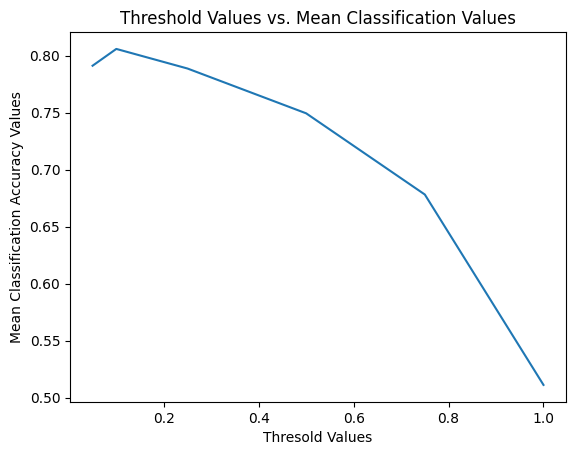

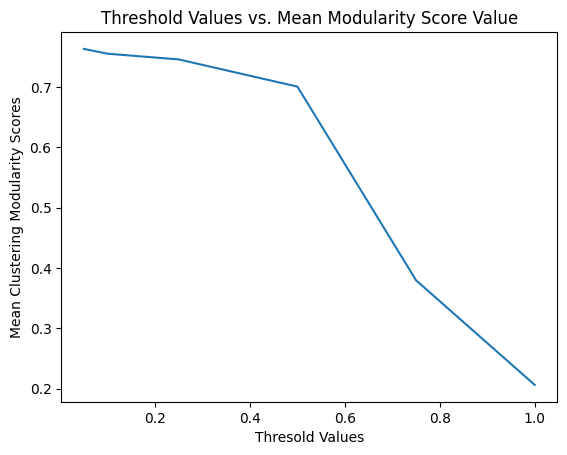

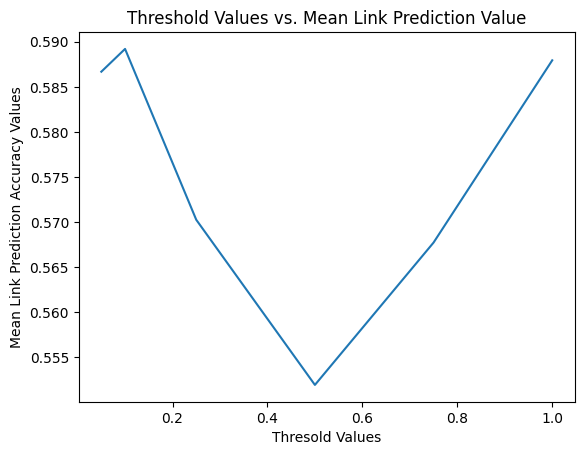

In [ ]:
# Classification

# Extract the keys and mean values
keys = list(classification_acc.keys())
means = [mean(item) for item in classification_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Classification Accuracy Values")
plt.title("Threshold Values vs. Mean Classification Values")
plt.show()


# K-Means

# Extract the keys and mean values
keys = list(modularity_score.keys())
means = [mean(item) for item in modularity_score.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Clustering Modularity Scores")
plt.title("Threshold Values vs. Mean Modularity Score Value")
plt.show()


# Link Classification

# Extract the keys and mean values
keys = list(link_pred_acc.keys())
means = [mean(item) for item in link_pred_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Link Prediction Accuracy Values")
plt.title("Threshold Values vs. Mean Link Prediction Value")
plt.show()

# Performing Tasks using Embeddings Sparsified by taking the Top K values

In [ ]:
def sparsify_embeddings_top_K_values(embeddings, K):
  sparsified_embeddings = {}
  for node, vector in embeddings.items():
    # Sort the vector, rearrange them in descending order and take the top K values
    sorted_vector = np.sort(vector)[::-1][:K]
    # Include only the values that are in the top K
    sparsified_vector = [val if val in sorted_vector else 0 for val in vector]
    sparsified_embeddings[node] = sparsified_vector

  return sparsified_embeddings

### Testing Top K Values Function

In [ ]:
K = 128 # You can pick any value from 1 to 128
kspdw_dict=sparsify_embeddings_top_K_values(dw_dict,K)
node_classification(kspdw_dict, labelfile)
cluster_eval(G1, kspdw_dict)
makeLinkPredictionData(G1, kspdw_dict)

Training classifier using 70.00% nodes...
-------------------
{'acc': 0.800982800982801}
-------------------
Number of clusters:  10   Modularity:  0.7594863698844437
Link predictions: 0.7 :Accuracy: 0.5781496684559521


### Top K over a range of K values

In [ ]:
# For every K value perform 10 iterations with different embeddings. Take average of the accuracy. Plot the accuracies


classification_acc = {}; modularity_score = {}; link_pred_acc = {}
K = [1, 5, 10, 25, 50, 75, 100, 128]; w_l = 20

for k in K:
  classification_acc[k] = []; modularity_score[k] = []; link_pred_acc[k] = []
  print(f"######For top {k} values######")
  for i in range(10):

    # walks_deepwalk = deepwalk_walks(G, walk_length=w_l, num_walks=80) # Generating new embeddings for every run so we can compute an average
    # embeddings_deepwalk = get_embedding(G,walks_deepwalk)
    # dw_dict=dict(list(embeddings_deepwalk.items()))


    kspdw_dict=sparsify_embeddings_top_K_values(dw_dict,k) # Sparsify Embeddings based on Top K values

    c_acc = node_classification(kspdw_dict, labelfile) # Node Classification
    classification_acc[k].append(c_acc)

    mod_score = cluster_eval(G1, kspdw_dict)  # K-Means Clustering
    modularity_score[k].append(mod_score)

    link_acc = makeLinkPredictionData(G1, kspdw_dict) # Link Prediction
    link_pred_acc[k].append(link_acc)



print(classification_acc.items())
print(modularity_score.items())
print(link_pred_acc.items())

######For top 1 values######
######For top 5 values######
######For top 10 values######
######For top 25 values######
######For top 50 values######
######For top 75 values######
######For top 100 values######
######For top 128 values######
dict_items([(1, [0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398, 0.4398034398034398]), (5, [0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725, 0.5724815724815725]), (10, [0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511, 0.6511056511056511]), (25, [0.7469287469287469, 0.7469287469287469, 0.7469287469287469, 0.7469287469287469, 0.7469287469287469, 0.7469287469287469, 

### Plotting the Averages

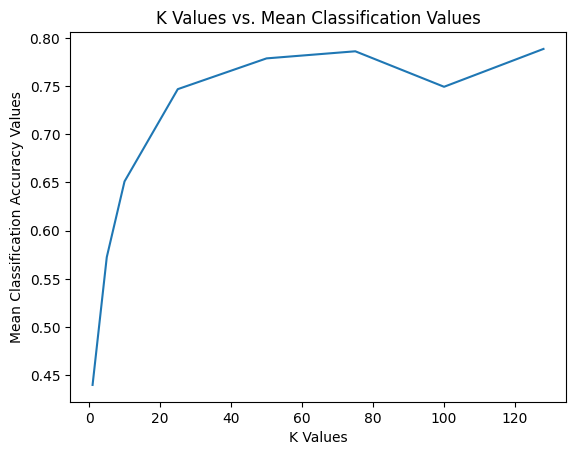

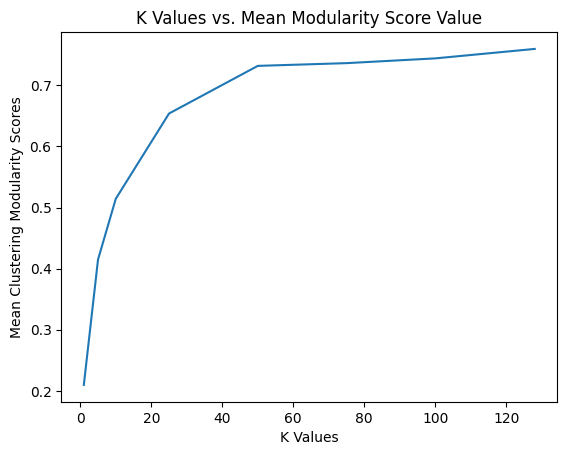

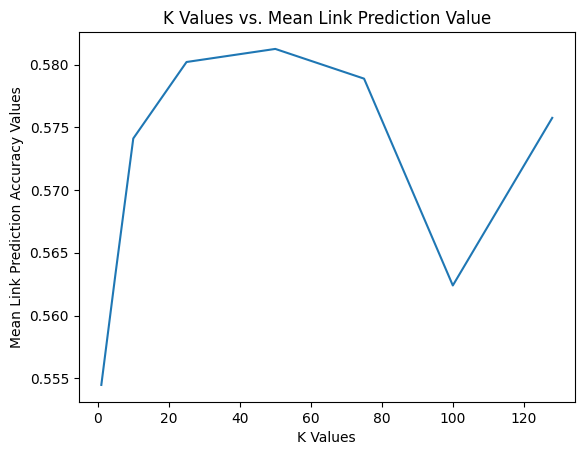

In [ ]:
# Classification

# Extract the keys and mean values
keys = list(classification_acc.keys())
means = [mean(item) for item in classification_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("K Values")
plt.ylabel("Mean Classification Accuracy Values")
plt.title("K Values vs. Mean Classification Values")
plt.show()


# K-Means

# Extract the keys and mean values
keys = list(modularity_score.keys())
means = [mean(item) for item in modularity_score.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("K Values")
plt.ylabel("Mean Clustering Modularity Scores")
plt.title("K Values vs. Mean Modularity Score Value")
plt.show()


# Link Classification

# Extract the keys and mean values
keys = list(link_pred_acc.keys())
means = [mean(item) for item in link_pred_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("K Values")
plt.ylabel("Mean Link Prediction Accuracy Values")
plt.title("K Values vs. Mean Link Prediction Value")
plt.show()

# Combined Code

### Generate 10 different embeddings

In [ ]:
# Generate 10 different embeddings and store them

dw_dict_10 = []; w_l=20

for i in range(10):

  walks_deepwalk = deepwalk_walks(G, walk_length=w_l, num_walks=80) # Generating new embeddings for every run so we can compute an average
  embeddings_deepwalk = get_embedding(G,walks_deepwalk)
  dw_dict=dict(list(embeddings_deepwalk.items()))
  dw_dict_10.append(dw_dict)

print(dw_dict_10)

Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!
Learning embedding vectors...


Learning embedding vectors done!


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/dw_dict_10.txt'
with open(filepath, 'w') as f:
  f.write(str(dw_dict_10))
from google.colab import files
files.download(filepath)

Mounted at /content/drive


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Percentages

In [ ]:
# For every K value perform 10 iterations with different embeddings. Take average of the accuracy. Plot the accuracies

P_classification_acc = {}; P_modularity_score = {}; P_link_pred_acc = {}; pspdw = []
vals=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]; w_l = 20

for p in vals:
  P_classification_acc[p] = []; P_modularity_score[p] = []; P_link_pred_acc[p] = []
  print(f"######Sparsifying {p*100}% of the embeddings######")
  for i in range(10):


    embedding = randomly_sparsify_embeddings(dw_dict_10[i],p) # Sparsify Embeddings by Randomly Removing Some % of Embeddings
    pspdw.append(embedding)

    c_acc = node_classification(embedding, labelfile) # Node Classification
    P_classification_acc[p].append(c_acc)

    mod_score = cluster_eval(G1, embedding)  # K-Means Clustering
    P_modularity_score[p].append(mod_score)

    link_acc = makeLinkPredictionData(G1, embedding) # Link Prediction
    P_link_pred_acc[p].append(link_acc)



print(P_classification_acc.items())
print(P_modularity_score.items())
print(P_link_pred_acc.items())

######Sparsifying 10.0% of the embeddings######
######Sparsifying 20.0% of the embeddings######
######Sparsifying 30.0% of the embeddings######
######Sparsifying 40.0% of the embeddings######
######Sparsifying 50.0% of the embeddings######
######Sparsifying 60.0% of the embeddings######
######Sparsifying 70.0% of the embeddings######
######Sparsifying 80.0% of the embeddings######
######Sparsifying 90.0% of the embeddings######
######Sparsifying 100% of the embeddings######
dict_items([(0.1, [0.7665847665847666, 0.7665847665847666, 0.7813267813267813, 0.7542997542997543, 0.7346437346437347, 0.7665847665847666, 0.7321867321867321, 0.7493857493857494, 0.7616707616707616, 0.7616707616707616]), (0.2, [0.7567567567567568, 0.7100737100737101, 0.7027027027027027, 0.7297297297297297, 0.7174447174447175, 0.7469287469287469, 0.7248157248157249, 0.7395577395577395, 0.7444717444717445, 0.7518427518427518]), (0.3, [0.7125307125307125, 0.6904176904176904, 0.6805896805896806, 0.6855036855036855, 0.72

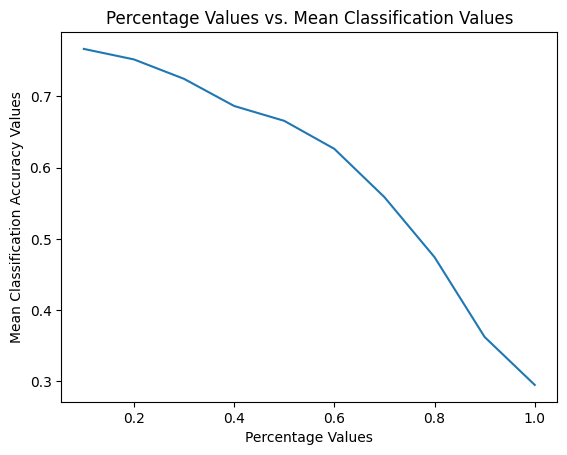

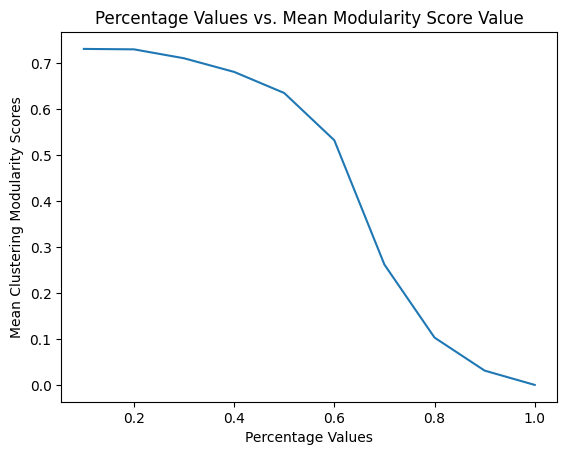

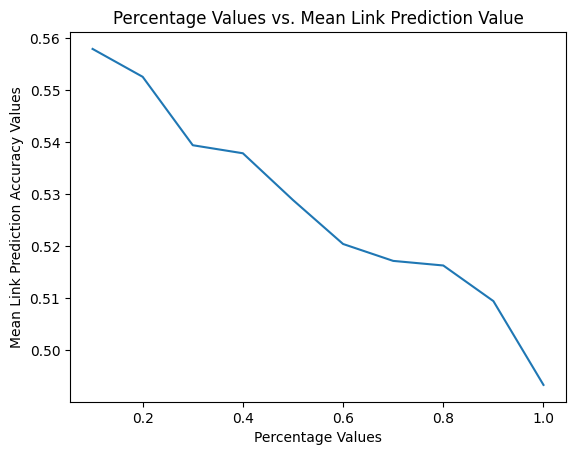

In [ ]:
# Classification

# Extract the keys and mean values
keys = list(P_classification_acc.keys())
means = [mean(item) for item in P_classification_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Percentage Values")
plt.ylabel("Mean Classification Accuracy Values")
plt.title("Percentage Values vs. Mean Classification Values")
plt.show()


# K-Means

# Extract the keys and mean values
keys = list(P_modularity_score.keys())
means = [mean(item) for item in P_modularity_score.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Percentage Values")
plt.ylabel("Mean Clustering Modularity Scores")
plt.title("Percentage Values vs. Mean Modularity Score Value")
plt.show()


# Link Classification

# Extract the keys and mean values
keys = list(P_link_pred_acc.keys())
means = [mean(item) for item in P_link_pred_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Percentage Values")
plt.ylabel("Mean Link Prediction Accuracy Values")
plt.title("Percentage Values vs. Mean Link Prediction Value")
plt.show()

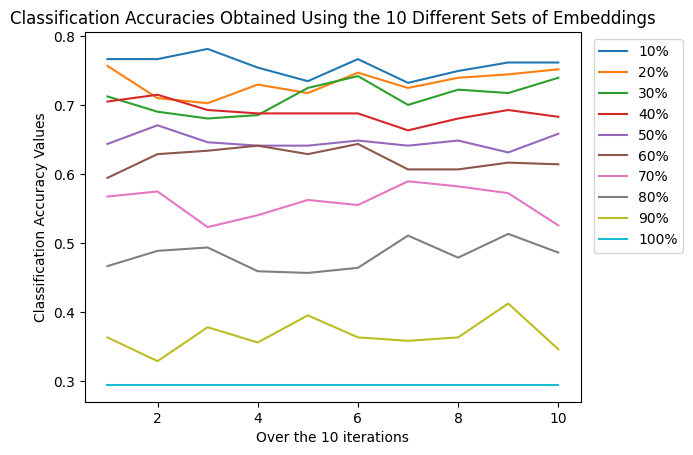

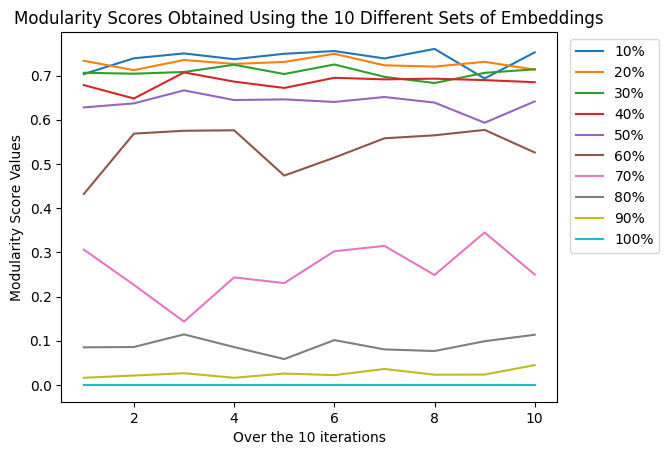

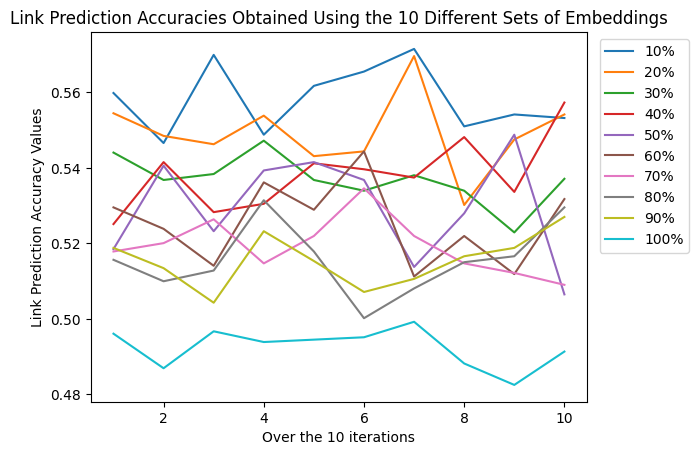

In [ ]:
# Classification

for key, values in P_classification_acc.items():
  plt.plot(range(1,11), values, label=f"{int(key*100)}%")
plt.xlabel("Over the 10 iterations")
plt.ylabel("Classification Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Classification Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# K-Means

for key, values in P_modularity_score.items():
  plt.plot(range(1,11), values, label=f"{int(key*100)}%")
plt.xlabel("Over the 10 iterations")
plt.ylabel("Modularity Score Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Modularity Scores Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# Link Prediction

for key, values in P_link_pred_acc.items():
  plt.plot(range(1,11), values, label=f"{int(key*100)}%")
plt.xlabel("Over the 10 iterations")
plt.ylabel("Link Prediction Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Link Prediction Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()

**Difference in Memory**

In [ ]:
temp_pspdw = deepcopy(pspdw)

for i in range(len(temp_pspdw)):
  for key, vector in temp_pspdw[i].items():
    sparsified_vector = np.array([val for val in vector if val!=0])
    temp_pspdw[i][key] = sparsified_vector

In [ ]:
print("Original Length of Embedding =", len(pspdw[1]['1057']), f"has a Size of {624} bytes in memory")

k_values = [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]

for k in k_values:
  print("Length of Embedding =", len(temp_pspdw[k]['1057']), f"has a size of {getsizeof(temp_pspdw[k]['1057'])} bytes in memory")

Original Length of Embedding = 128 has a Size of 624 bytes in memory
Length of Embedding = 116 has a size of 576 bytes in memory
Length of Embedding = 103 has a size of 524 bytes in memory
Length of Embedding = 90 has a size of 472 bytes in memory
Length of Embedding = 77 has a size of 420 bytes in memory
Length of Embedding = 64 has a size of 368 bytes in memory
Length of Embedding = 52 has a size of 320 bytes in memory
Length of Embedding = 39 has a size of 268 bytes in memory
Length of Embedding = 26 has a size of 216 bytes in memory
Length of Embedding = 13 has a size of 164 bytes in memory
Length of Embedding = 0 has a size of 112 bytes in memory


In [ ]:
# Sample nd arrays of lengths 128 & 116's sizes in memory


import numpy as np

# Create a numpy ndarray with length 128
ndarray_128 = np.random.rand(128)

# Create a numpy ndarray with length 116
ndarray_116 = np.random.rand(116)

print(getsizeof(ndarray_128))
print(getsizeof(ndarray_116))

1136
1040


### Threshold

In [ ]:
# For every K value perform 10 iterations with different embeddings. Take average of the accuracy. Plot the accuracies

T_classification_acc = {}; T_modularity_score = {}; T_link_pred_acc = {}; tspdw = []
T = [0.05, 0.1, 0.25, 0.5, 0.75, 1]; w_l = 20

for t in T:
  T_classification_acc[t] = []; T_modularity_score[t] = []; T_link_pred_acc[t] = []
  print(f"######Sparsifying embeddings which are less than {t}######")
  for i in range(10):


    embedding = sparsify_embeddings_above_magnitude(dw_dict_10[i],t) # Sparsify Embeddings based on Top K values
    tspdw.append(embedding)

    c_acc = node_classification(embedding, labelfile) # Node Classification
    T_classification_acc[t].append(c_acc)

    mod_score = cluster_eval(G1, embedding)  # K-Means Clustering
    T_modularity_score[t].append(mod_score)

    link_acc = makeLinkPredictionData(G1, embedding) # Link Prediction
    T_link_pred_acc[t].append(link_acc)



print(T_classification_acc.items())
print(T_modularity_score.items())
print(T_link_pred_acc.items())

######Sparsifying embeddings which are less than 0.05######
######Sparsifying embeddings which are less than 0.1######
######Sparsifying embeddings which are less than 0.25######
######Sparsifying embeddings which are less than 0.5######
######Sparsifying embeddings which are less than 0.75######
######Sparsifying embeddings which are less than 1######
dict_items([(0.05, [0.7665847665847666, 0.7714987714987716, 0.7862407862407862, 0.7788697788697788, 0.7665847665847666, 0.7665847665847666, 0.7592137592137592, 0.7714987714987716, 0.7837837837837838, 0.7788697788697788]), (0.1, [0.769041769041769, 0.769041769041769, 0.7837837837837838, 0.7837837837837838, 0.7616707616707616, 0.769041769041769, 0.7567567567567568, 0.7764127764127764, 0.7837837837837838, 0.7788697788697788]), (0.25, [0.773955773955774, 0.7567567567567568, 0.7665847665847666, 0.7788697788697788, 0.7592137592137592, 0.7616707616707616, 0.7592137592137592, 0.7837837837837838, 0.7886977886977887, 0.7788697788697788]), (0.5, [0

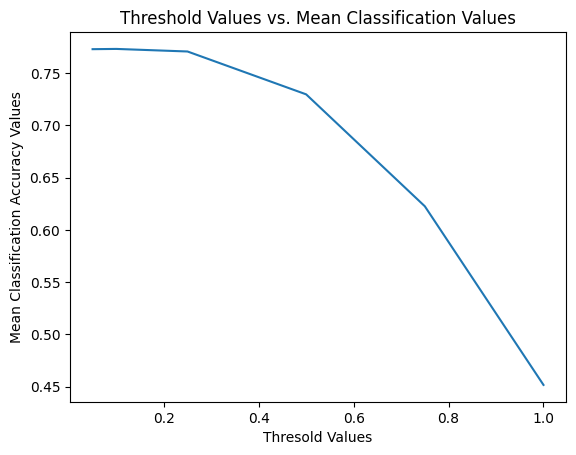

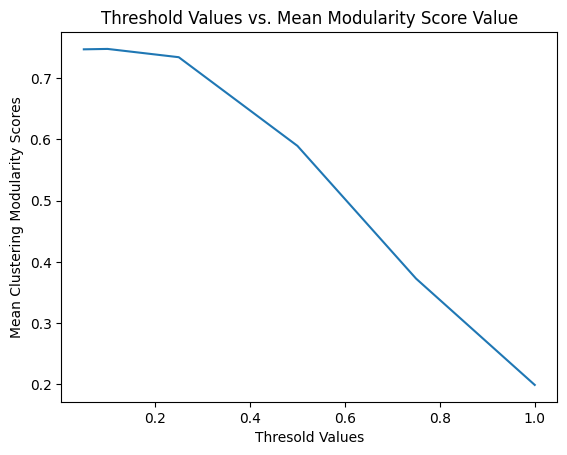

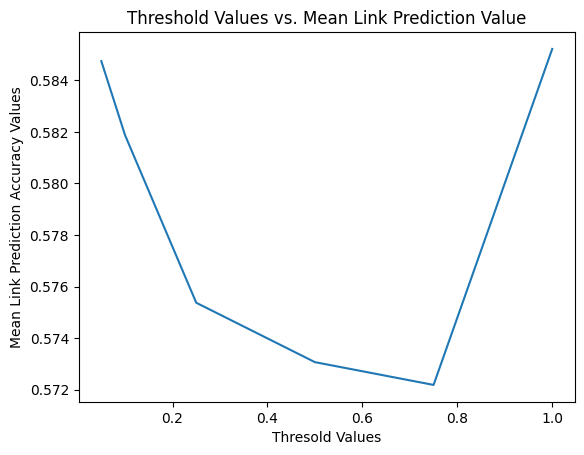

In [ ]:
# Classification

# Extract the keys and mean values
keys = list(T_classification_acc.keys())
means = [mean(item) for item in T_classification_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Classification Accuracy Values")
plt.title("Threshold Values vs. Mean Classification Values")
plt.show()


# K-Means

# Extract the keys and mean values
keys = list(T_modularity_score.keys())
means = [mean(item) for item in T_modularity_score.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Clustering Modularity Scores")
plt.title("Threshold Values vs. Mean Modularity Score Value")
plt.show()


# Link Classification

# Extract the keys and mean values
keys = list(T_link_pred_acc.keys())
means = [mean(item) for item in T_link_pred_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("Thresold Values")
plt.ylabel("Mean Link Prediction Accuracy Values")
plt.title("Threshold Values vs. Mean Link Prediction Value")
plt.show()

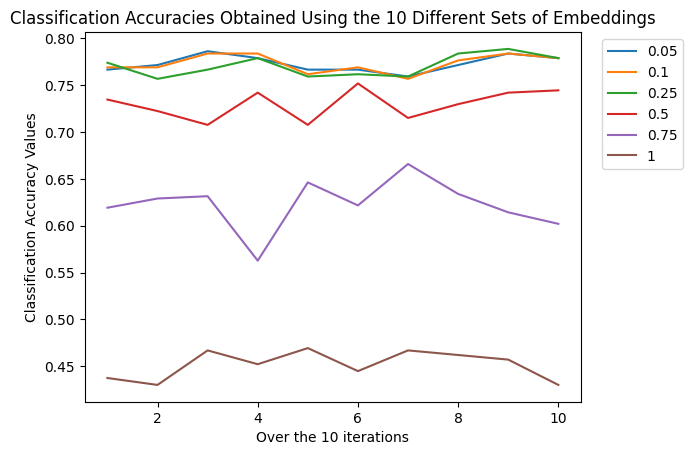

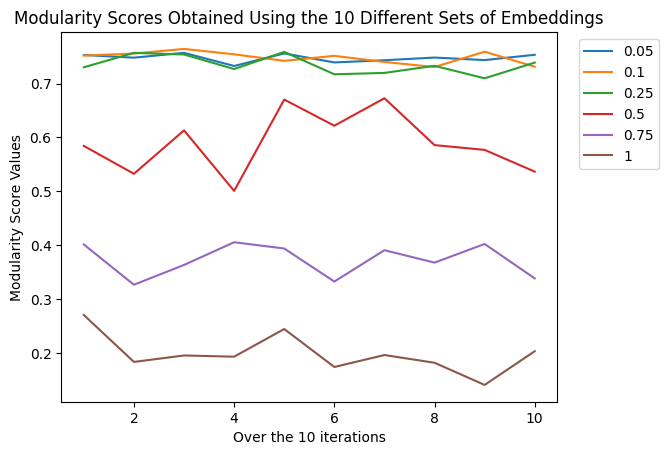

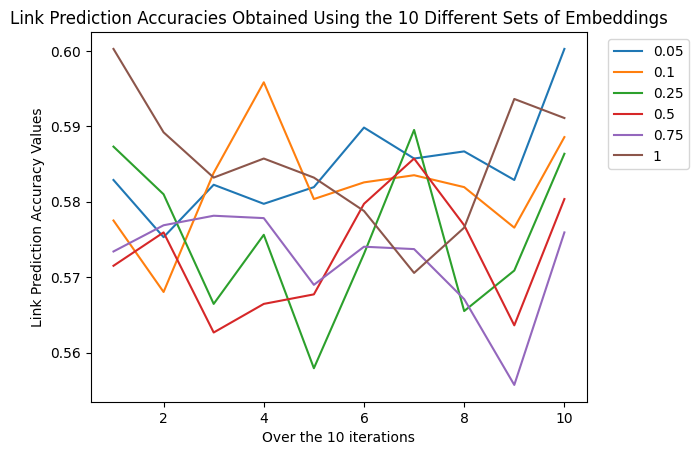

In [ ]:
# Classification

for key, values in T_classification_acc.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Classification Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Classification Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# K-Means

for key, values in T_modularity_score.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Modularity Score Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Modularity Scores Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# Link Prediction

for key, values in T_link_pred_acc.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Link Prediction Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Link Prediction Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()

**Difference in Memory**

In [ ]:
temp_tspdw = deepcopy(tspdw)

for i in range(len(temp_tspdw)):
  for key, vector in temp_tspdw[i].items():
    sparsified_vector = np.array([val for val in vector if val!=0])
    temp_tspdw[i][key] = sparsified_vector

In [ ]:
print("Original Length of Embedding =", len(tspdw[1]['1057']), f"has a Size of {624} bytes in memory")

k_values = [1, 11, 21, 31, 41];

for k in k_values:
  print("Length of Embedding =", len(temp_tspdw[k]['1057']), f"has a size of {getsizeof(temp_tspdw[k]['1057'])} bytes in memory")

Original Length of Embedding = 128 has a Size of 624 bytes in memory
Length of Embedding = 98 has a size of 504 bytes in memory
Length of Embedding = 74 has a size of 408 bytes in memory
Length of Embedding = 22 has a size of 200 bytes in memory
Length of Embedding = 2 has a size of 120 bytes in memory
Length of Embedding = 0 has a size of 112 bytes in memory


### Top K Values

In [ ]:
# For every K value perform 10 iterations with different embeddings. Take average of the accuracy. Plot the accuracies


K_classification_acc = {}; K_modularity_score = {}; K_link_pred_acc = {}; kspdw = []
K = [1, 5, 10, 25, 50, 75, 100, 128]; w_l = 20

for k in K:
  K_classification_acc[k] = []; K_modularity_score[k] = []; K_link_pred_acc[k] = []
  print(f"######For top {k} values######")
  for i in range(10):


    embedding=sparsify_embeddings_top_K_values(dw_dict_10[i],k) # Sparsify Embeddings based on Top K values
    kspdw.append(embedding)

    c_acc = node_classification(embedding, labelfile) # Node Classification
    K_classification_acc[k].append(c_acc)

    mod_score = cluster_eval(G1, embedding)  # K-Means Clustering
    K_modularity_score[k].append(mod_score)

    link_acc = makeLinkPredictionData(G1, embedding) # Link Prediction
    K_link_pred_acc[k].append(link_acc)



print(K_classification_acc.items())
print(K_modularity_score.items())
print(K_link_pred_acc.items())

######For top 1 values######
######For top 5 values######
######For top 10 values######
######For top 25 values######
######For top 50 values######
######For top 75 values######
######For top 100 values######
######For top 128 values######
dict_items([(1, [0.43243243243243246, 0.4004914004914005, 0.32678132678132676, 0.3857493857493858, 0.3857493857493858, 0.3095823095823096, 0.3832923832923833, 0.35626535626535627, 0.36609336609336607, 0.3931203931203931]), (5, [0.5749385749385749, 0.5798525798525799, 0.5773955773955773, 0.5872235872235873, 0.6068796068796068, 0.5601965601965602, 0.597051597051597, 0.5331695331695332, 0.5724815724815725, 0.597051597051597]), (10, [0.6560196560196561, 0.6339066339066339, 0.6437346437346437, 0.6314496314496314, 0.6511056511056511, 0.6486486486486487, 0.6609336609336609, 0.6167076167076168, 0.6388206388206388, 0.6805896805896806]), (25, [0.7248157248157249, 0.7002457002457002, 0.6904176904176904, 0.7174447174447175, 0.7125307125307125, 0.7272727272727273

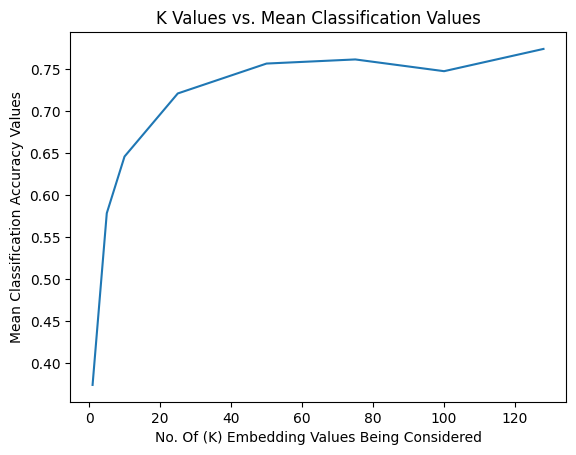

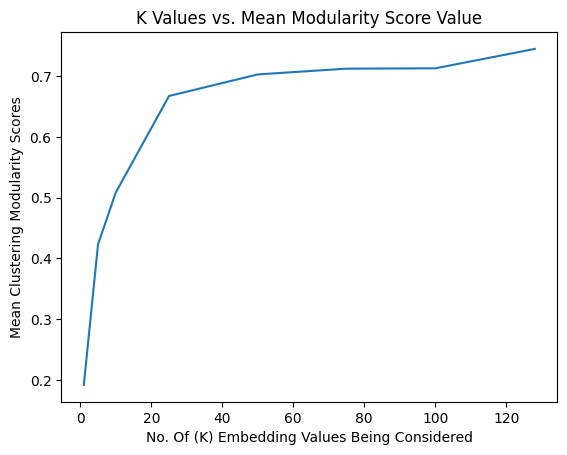

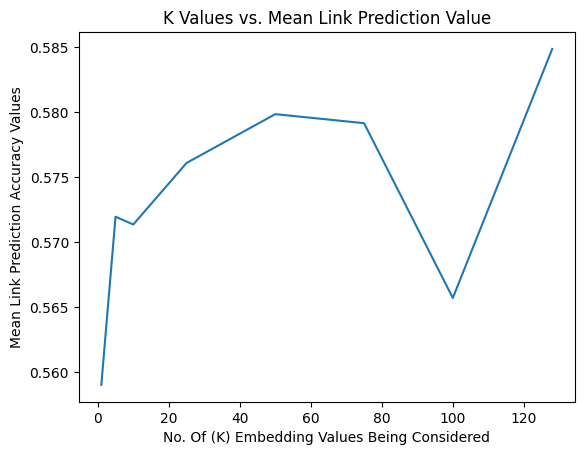

In [ ]:
# Classification

# Extract the keys and mean values
keys = list(K_classification_acc.keys())
means = [mean(item) for item in K_classification_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("No. Of (K) Embedding Values Being Considered")
plt.ylabel("Mean Classification Accuracy Values")
plt.title("K Values vs. Mean Classification Values")
plt.show()


# K-Means

# Extract the keys and mean values
keys = list(K_modularity_score.keys())
means = [mean(item) for item in K_modularity_score.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("No. Of (K) Embedding Values Being Considered")
plt.ylabel("Mean Clustering Modularity Scores")
plt.title("K Values vs. Mean Modularity Score Value")
plt.show()


# Link Classification

# Extract the keys and mean values
keys = list(K_link_pred_acc.keys())
means = [mean(item) for item in K_link_pred_acc.values()]

# Create the plot
plt.plot(keys, means)
plt.xlabel("No. Of (K) Embedding Values Being Considered")
plt.ylabel("Mean Link Prediction Accuracy Values")
plt.title("K Values vs. Mean Link Prediction Value")
plt.show()

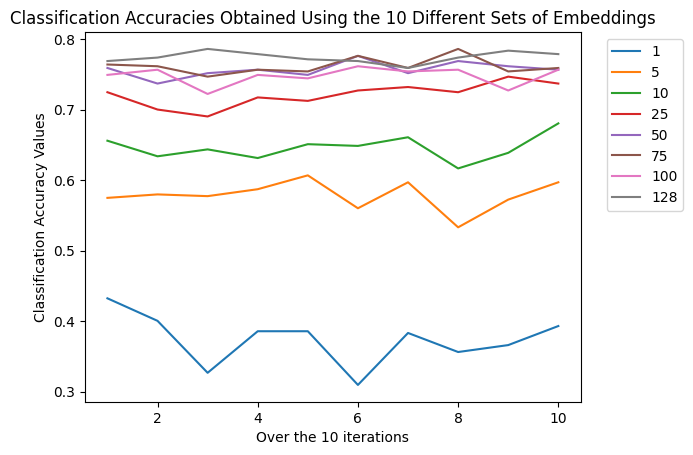

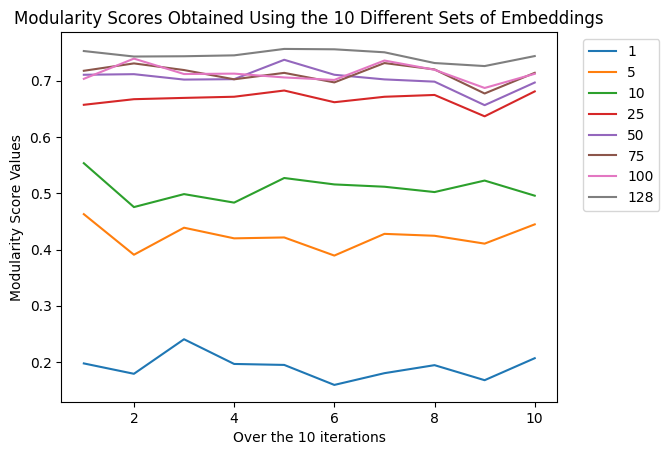

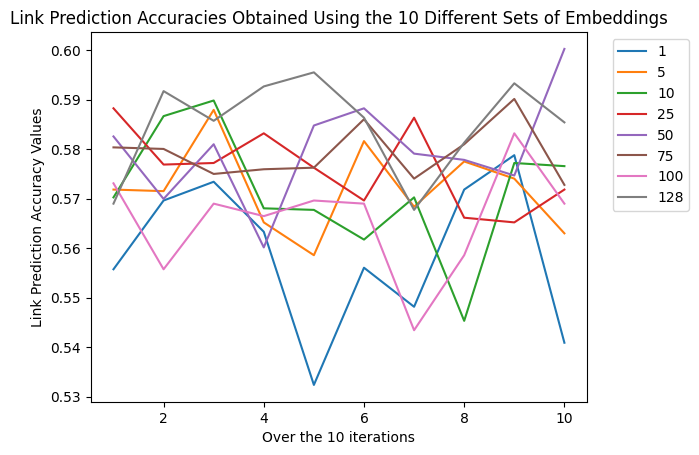

In [ ]:
# Classification

for key, values in K_classification_acc.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Classification Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Classification Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# K-Means

for key, values in K_modularity_score.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Modularity Score Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Modularity Scores Obtained Using the 10 Different Sets of Embeddings")
plt.show()


# Link Prediction

for key, values in K_link_pred_acc.items():
  plt.plot(range(1,11), values, label=key)
plt.xlabel("Over the 10 iterations")
plt.ylabel("Link Prediction Accuracy Values")
plt.legend(bbox_to_anchor=(1.02, 0, 0.2, 1))
plt.title("Link Prediction Accuracies Obtained Using the 10 Different Sets of Embeddings")
plt.show()

**Difference in Memory**

In [ ]:
temp_kspdw = deepcopy(kspdw)

for i in range(len(temp_kspdw)):
  for key, vector in temp_kspdw[i].items():
    sparsified_vector = np.array([val for val in vector if val!=0])
    temp_kspdw[i][key] = sparsified_vector

In [ ]:
print("Original Length of Embedding =", len(kspdw[1]['1057']), f"has a Size of {624} bytes in memory")

k_values = [1, 11, 21, 31, 41, 51, 61, 71]; lengths = [128]; memory_size = [624]

for k in k_values:
  print("Length of Embedding =", len(temp_kspdw[k]['1057']), f"has a size of {getsizeof(temp_kspdw[k]['1057'])} bytes in memory")
  lengths.append(len(temp_kspdw[k]['1057']))
  memory_size.append(getsizeof(temp_kspdw[k]['1057']))

Original Length of Embedding = 128 has a Size of 624 bytes in memory
Length of Embedding = 1 has a size of 116 bytes in memory
Length of Embedding = 5 has a size of 132 bytes in memory
Length of Embedding = 10 has a size of 152 bytes in memory
Length of Embedding = 25 has a size of 212 bytes in memory
Length of Embedding = 50 has a size of 312 bytes in memory
Length of Embedding = 75 has a size of 412 bytes in memory
Length of Embedding = 100 has a size of 512 bytes in memory
Length of Embedding = 128 has a size of 624 bytes in memory


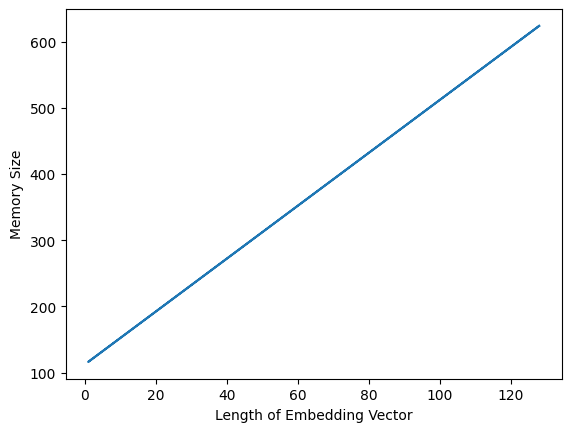

In [ ]:
plt.plot(lengths, memory_size)
plt.xlabel("Length of Embedding Vector")
plt.ylabel("Memory Size")
plt.show()
# plt.title("Link Prediction Accuracies Obtained Using the 10 Different Sets of Embeddings")
